## Import some helpful libraries

In [1]:
print("    Version control\n------------------------")
import os, fnmatch, random, math, sys, datetime
from pathlib import Path
import numpy as np;              print("Numpy\t\t", np.__version__)
import matplotlib as mpl;        print("matplotlib\t", mpl.__version__)
import matplotlib.pyplot as plt
import nibabel as nib;           print("NiBabel\t\t {}".format(nib.__version__))
from nibabel.testing import data_path
import pandas as pd;             print("Pandas\t\t {}".format(pd.__version__))
import imageio;                  print("imageio\t\t {}".format(imageio.__version__))
import h5py;                     print("H5py\t\t {}".format(h5py.__version__))
import sklearn;                  print("Scikit-learn\t {}".format(sklearn.__version__))
import skimage;                  print("Scikit-image\t {}".format(skimage.__version__))
import tensorflow as tf;         print("TensorFlow\t {}".format(tf.__version__))
import keras as K;               print("Keras\t\t {}".format(K.__version__))
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, Conv3D, MaxPooling3D, UpSampling3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.initializers import *
from keras.callbacks import TensorBoard, EarlyStopping
%load_ext tensorboard
# %reload_ext tensorboard

    Version control
------------------------
Numpy		 1.19.4
matplotlib	 3.3.3
NiBabel		 3.2.0
Pandas		 1.1.4
imageio		 2.9.0
H5py		 2.10.0
Scikit-learn	 0.23.2
Scikit-image	 0.17.2
TensorFlow	 2.3.1
Keras		 2.3.1


Using TensorFlow backend.


## Loading Dataset

In [2]:
## Load train data
sample_train_subset = np.loadtxt("sample_train_1.csv", dtype=str, delimiter=",")
train_data = np.load('train_1.npy').reshape(100,182,218,182,1)
print('train_data shape is {}'.format(train_data.shape))

## Load validation data
sample_val_subset = np.loadtxt("sample_valid_1.csv", dtype=str, delimiter=",")
valid_data = np.load('valid_1.npy').reshape(24,182,218,182,1)
print('valid_data shape is {}'.format(valid_data.shape))

## Load last weights
# last_weights = str(Path(os.path.join(os.getcwd(), "Weights")) / "w_1.hdf5")
# print(last_weights)

train_data shape is (100, 182, 218, 182, 1)
valid_data shape is (24, 182, 218, 182, 1)


In [3]:
# print("There are", len(sample_train_subset), " subset of train samples are:\n")
# print(*sample_train_subset, sep='\t')
# print("\n--------------------------------------------------------------------------------\n")
# print("There are", len(sample_val_subset), " subset of Validation samples are:\n")
# print(*sample_val_subset, sep='\t')

In [4]:
## Showing one or all Training samples in three dimension (one middle slice per each dimension)

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray
        
# for m in range(train_data.shape[0]):
for m in range(1):
    slice_0 = train_data[m, 91, :, :, 0]
    slice_1 = train_data[m, :, 109, :, 0]
    slice_2 = train_data[m, :, :, 91, 0]
#     show_slices([slice_0, slice_1, slice_2])
#     plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

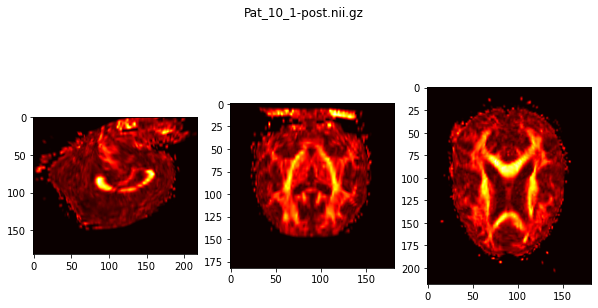

In [5]:
## Showing one or all Validation samples in three dimension (one middle slice per each dimension)

# for m in range(valid_data.shape[0]):
for m in range(1):
    slice_0 = valid_data[m, 91, :, :, 0]
    slice_1 = valid_data[m, :, 109, :, 0]
    slice_2 = valid_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_val_subset[m], x=0.5, y=1)

## Model Design

In [328]:
## Test simple model:

IMAGE_HEIGHT = train_data.shape[1]
IMAGE_WIDTH = train_data.shape[2]
IMAGE_DEPTH = train_data.shape[3]
batch_size = 1
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_img = Input(shape=(182, 218, 182, 1), name='Input')
x = Conv3D(filters=1, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv1')(input_img)
x = BatchNormalization(name='BN_Conv1')(x)
x = Conv3D(filters=1, kernel_size=1, padding='valid', activation='relu', name='DeConv6')(x)
x = BatchNormalization(name='BN_DeConv1')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling1')(x)
decoded = Conv3D(filters=1, kernel_size=3, padding='same', activation='sigmoid', name='Output')(x)
model_CAE = Model(inputs=input_img, outputs=decoded)
model_CAE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_CAE.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 182, 218, 182, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 91, 109, 91, 1)    28        
_________________________________________________________________
BN_Conv1 (BatchNormalization (None, 91, 109, 91, 1)    4         
_________________________________________________________________
DeConv6 (Conv3D)             (None, 91, 109, 91, 1)    2         
_________________________________________________________________
BN_DeConv1 (BatchNormalizati (None, 91, 109, 91, 1)    4         
_________________________________________________________________
UpSampling1 (UpSampling3D)   (None, 182, 218, 182, 1)  0         
_________________________________________________________________
Output (Conv3D)              (None, 182, 218, 182, 1)

In [330]:
## Define parameters:

IMAGE_HEIGHT = train_data.shape[1]
IMAGE_WIDTH = train_data.shape[2]
IMAGE_DEPTH = train_data.shape[3]
batch_size = 1
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("input-layer shape:", input_shape)

## Encoder
input_img = Input(shape=(182, 218, 182, 1), name='Input')
x = Conv3D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv1')(input_img)
x = BatchNormalization(name='BN_Conv1')(x)
x = Conv3D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv2')(x)
x = BatchNormalization(name='BN_Conv2')(x)
x = Conv3D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv3')(x)
x = BatchNormalization(name='BN_Conv3')(x)
x = Conv3D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv4')(x)
x = BatchNormalization(name='BN_Conv4')(x)
x = Conv3D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv5')(x)
x = BatchNormalization(name='BN_Conv5')(x)
x = Conv3D(filters=4, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv6')(x)
x = BatchNormalization(name='BN_Conv6')(x)

## Latent Features
shape_before_flattening = tf.keras.backend.int_shape(x)
x = Flatten(name='Flat')(x)
# init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
# encoded = Dense(50, kernel_initializer=init, activation='relu', name='encoded')(x)
# encoded = Dense(50, activation='relu', name='encoded')(x)
encoded = x
# x = BatchNormalization()(encoded)
# x = Dense(np.prod(shape_before_flattening[1:]), activation='relu', kernel_initializer=init)(encoded)
# x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(encoded)
x = Reshape(shape_before_flattening[1:], name='UnFlat')(x)

## Decoder
x = Conv3D(filters=4, kernel_size=3, padding='same', activation='relu', name='DeConv1')(x)
x = BatchNormalization(name='BN_DeConv1')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling1')(x)
x = Conv3D(filters=8, kernel_size=(1,2,1), padding='valid', activation='relu', name='DeConv2')(x)
x = BatchNormalization(name='BN_DeConv2')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling2')(x)
x = Conv3D(filters=16, kernel_size=3, padding='same', activation='relu', name='DeConv3')(x)
x = BatchNormalization(name='BN_DeConv3')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling3')(x)
x = Conv3D(filters=32, kernel_size=(2,1,2), padding='valid', activation='relu', name='DeConv4')(x)
x = BatchNormalization(name='BN_DeConv4')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling4')(x)
x = Conv3D(filters=64, kernel_size=(1,2,1), padding='valid', activation='relu', name='DeConv5')(x)
x = BatchNormalization(name='BN_DeConv5')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling5')(x)
x = Conv3D(filters=128, kernel_size=2, padding='valid', activation='relu', name='DeConv6')(x)
x = BatchNormalization(name='BN_DeConv6')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling6')(x)
decoded = Conv3D(filters=1, kernel_size=3, padding='same', activation='sigmoid', name='Output')(x)

model_CAE = Model(inputs=input_img, outputs=decoded)
## optimizer=rmsprop, sgd
model_CAE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_CAE.summary()

input-layer shape: [1, 182, 218, 182, 1]
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 182, 218, 182, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 91, 109, 91, 128)  3584      
_________________________________________________________________
BN_Conv1 (BatchNormalization (None, 91, 109, 91, 128)  512       
_________________________________________________________________
Conv2 (Conv3D)               (None, 46, 55, 46, 64)    221248    
_________________________________________________________________
BN_Conv2 (BatchNormalization (None, 46, 55, 46, 64)    256       
_________________________________________________________________
Conv3 (Conv3D)               (None, 23, 28, 23, 32)    55328     
_________________________________________________________________
BN_Conv3 (Ba

## Model Training

In [7]:
## Loading last weights
model_CAE.load_weights(os.path.join("Weights/Weights_L100___2020_12_30___03_43_23.hdf5"))

In [13]:
## Start time:
from datetime import datetime
start_time = datetime.now().strftime("%Y.%m.%d___%H:%M")
print("\nStart Time =", start_time, "\n")

## Model Fit
tb_callback = TensorBoard(os.path.join("Logs/L100___" + start_time), histogram_freq=1)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
model_CAE.fit(train_data, train_data, validation_data=(valid_data, valid_data), epochs=1, batch_size=batch_size, shuffle=True, callbacks=[tb_callback], verbose=1)
model_CAE.save_weights(os.path.join("Weights/L100___" + start_time + ".hdf5"))

## End time:
from datetime import datetime
end_time = datetime.now().strftime("%Y_%m_%d____%H_%M")
print("\nEnd Time =", end_time)


Start Time = 2020_12_30____04_36_21 

100/100 [==============================] - 460s 5s/step - loss: 0.0305 - accuracy: 0.7023 - val_loss: 0.0209 - val_accuracy: 0.7067


OSError: Unable to create file (unable to open file: name = 'Weights/Weights_L100___/2020_12_30____04_36_21/.hdf5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

In [26]:
model_CAE.save_weights(os.path.join("Weights/L100___" + start_time + ".hdf5"))

In [10]:
test_data = valid_data[0,:].reshape(1, 182, 218, 182, 1)
reconstructed = model_CAE.predict(test_data)

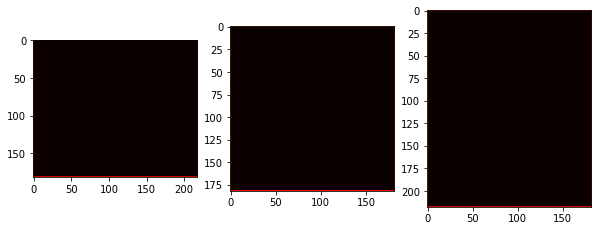

In [11]:
for m in range(1):
    slice_0 = reconstructed[m, 91, :, :, 0]
    slice_1 = reconstructed[m, :, 109, :, 0]
    slice_2 = reconstructed[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])

In [12]:
print('\ntrain_data[0,100,100:105,100]\n\n {}'.format(train_data[0,100,100:105,100]),'\n')
print('\nReconstructed_data[0,100,100:105,100]\n\n {}'.format(reconstructed[0,100,100:105,100]),'\n')


train_data[0,100,100:105,100]

 [[0.55211586]
 [0.51723999]
 [0.52700305]
 [0.62761533]
 [0.59050184]] 


Reconstructed_data[0,100,100:105,100]

 [[0.24101308]
 [0.24101308]
 [0.24101308]
 [0.24101308]
 [0.24101308]] 



In [241]:
L = h5_file[list(h5_file.keys())[0]]
W = L[list(h5_file.keys())[0]]['kernel:0']
print('\nWeights shape: {}'.format(W.shape))
print('\nWeights[1][1][1]: {}'.format(W[1][1][1]))


Weights shape: (3, 3, 3, 1, 64)

Weights[1][1][1]: [[-0.02180088 -0.02930861 -0.04297562 -0.08140913  0.00147109  0.10459905
   0.00731917 -0.20524469  0.23248568 -0.00080663 -0.05673174 -0.01014277
  -0.01166705 -0.10060673 -0.09122061  0.02244971 -0.04892787 -0.2383175
  -0.0714208   0.04633898  0.0019404   0.03212474 -0.01953408 -0.02794567
   0.5020561  -0.06592676  0.00309188  0.00887992 -0.01632981  0.3118059
  -0.04564438 -0.0339375  -0.06243201 -0.3027727  -0.17903858 -0.0397261
  -0.02897952  0.12904522  0.17720857 -0.08123126 -0.22215109  0.4372661
  -0.02913703 -0.19113037 -0.02633037 -0.07390606 -0.02956062  0.14482746
  -0.0126915  -0.08701103  0.00804431 -0.00709525 -0.3571501   0.20331356
   0.0353299  -0.07104006 -0.08331616 -0.00445606 -0.06370134 -0.02907308
   0.303389    0.00666074  0.0062249  -0.01085626]]


In [320]:
# h5_file = h5py.File(os.path.join("Weights/L100___" + start_time + ".hdf5"), 'r')
h5_file = h5py.File(os.path.join("Weights/w_Pegasus_128.hdf5"), 'r')
Layer_size = len(list(h5_file.keys()))
Layer_names = list(h5_file.keys())
print("There are", Layer_size, "layers in this model as:\n\n", Layer_names,'\n')

for l in range(5):  #Layer_size
    print('==========================================================\n')
    layers = h5_file[Layer_names[l]]
#     print("Layer", l+1, "-----", layers)
    W = layers[Layer_names[l]]['kernel:0']
    print('Layer', l+1, ':', list(h5_file.keys())[l], '\tWeights\' shape: {}'.format(W.shape), '\n')
#     print('\nWeights[1][1][1]: {}'.format(W[1][1][1]))
    
    Kernel_1 = W.shape[0]
    Kernel_2 = W.shape[1]
    Kernel_3 = W.shape[2]
    Kernel_all = np.zeros([Kernel_1, Kernel_2, Kernel_3])
    for f in range(2):   # W.shape[4]
        for x in range(Kernel_1):
            for y in range(Kernel_2):
                for z in range(Kernel_3):
                    Kernel_all[x][y][z] = (W[x][y][z])[0][0]
        print('\nWeights of kernel', f+1, 'of', W.shape[4], ':\n\n', Kernel_all)


There are 17 layers in this model as:

 ['Conv1', 'Conv2', 'Conv3', 'DeConv1', 'DeConv2', 'DeConv3', 'Output', 'batch_normalization', 'batch_normalization_1', 'batch_normalization_2', 'batch_normalization_3', 'batch_normalization_4', 'batch_normalization_5', 'input_1', 'up_sampling3d', 'up_sampling3d_1', 'up_sampling3d_2'] 


Layer 1 : Conv1 	Weights' shape: (3, 3, 3, 1, 64) 


Weights of kernel 1 of 64 :

 [[[-0.03236854 -0.14316913 -0.13911112]
  [-0.05437694  0.00110877  0.02125892]
  [-0.02176703  0.04296681  0.04505903]]

 [[ 0.0099239  -0.07856947 -0.0984294 ]
  [-0.00154239 -0.02180088 -0.02031503]
  [-0.01293995 -0.01628701  0.02513998]]

 [[ 0.26138464  0.16107135  0.12669967]
  [ 0.3406086   0.24986073  0.20581758]
  [ 0.19243112  0.21549019  0.13506231]]]

Weights of kernel 2 of 64 :

 [[[-0.03236854 -0.14316913 -0.13911112]
  [-0.05437694  0.00110877  0.02125892]
  [-0.02176703  0.04296681  0.04505903]]

 [[ 0.0099239  -0.07856947 -0.0984294 ]
  [-0.00154239 -0.02180088 -0.

In [ ]:
# tensorboard --logdir=Logs       # http://localhost:6006/